In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools
from tqdm import tqdm
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree


In [ ]:
# reward_p = np.array(
#     [
#         [0, 0],
#         [1, 5],
#         [4, 2],
#         [7, 8],
#         [3, 6],
#         [8, 3],
#         [2, 9],
#         [6, 7],
#         [9, 1],
#         [5, 4],
#         [7, 2],
#         [10, 5],
#         [12, 4],
#         [11, 7],
#         [14, 9],
#         [13, 3],
#         [9, 6],
#         [15, 8],
#         [16, 2],
#         [18, 5],
#         [20, 3],
#     ]
# )

# reward_value = np.array(
#     [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105]
# )

grid_size = 5
spacing = 3

reward_p = np.array([
    [i * spacing, j * spacing] 
    for i in range(grid_size) 
    for j in range(grid_size)
])

reward_value = np.array(
    [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 37, 52, 40, 28]
)
print(reward_p.shape[0], reward_value.shape[0])

NUM_REWARDS = reward_p.shape[0]

POP_SIZE = 500
NUM_GEN = 150

CX_PROB = 0.8
MUT_PROB = 0.7
MUT_DECAY_RATE = 0.5
TOURNAMENT_SIZE = 2

MAX_DISTANCE_BETWEEN_AGENTS = 3
BUDGET = 35
PROXIMITY_GAIN = 0.1

dist_mx = cdist(reward_p, reward_p, metric="euclidean")
kdtree = KDTree(reward_p)


25 25


In [3]:
def add_neighbor_values(rvalues: np.ndarray, rpositions: np.ndarray, kdtree: KDTree, maxdist: np.ndarray) -> np.ndarray:
    rvalues = np.array(rvalues)
    for i, pos in enumerate(rpositions):
        neighbors = kdtree.query_radius([pos], r=maxdist)[0]
        rvalues[i] = rvalues[i] + max(rvalues[neighbors])
    return rvalues
reward_value = add_neighbor_values(reward_value, reward_p, kdtree, MAX_DISTANCE_BETWEEN_AGENTS)

In [4]:
def get_last_valid_idx(path):
    total_distance = 0
    curr_reward = 0

    valid_idx = 0
    for i in range(len(path)):
        next_reward = path[i]
        total_distance += dist_mx[curr_reward, next_reward]
        if total_distance > BUDGET:
            break
        valid_idx = i
        curr_reward = next_reward
    return valid_idx

In [5]:
def minimize_distance(ind: list) -> float:
    total_distance = 0
    curr_reward = 0

    for next_reward in ind:
        total_distance += dist_mx[curr_reward, next_reward]
        curr_reward = next_reward

    return total_distance


def maximize_reward(ind: list) -> float:
    last_idx = get_last_valid_idx(ind)
    reward = 0

    for i in range(last_idx + 1):
        next_reward = ind[i]
        reward += reward_value[next_reward]
    return reward


def maximize_team_gain(ind: list) -> float:
    last_idx = get_last_valid_idx(ind)
    team_gain = 0

    for i in range(last_idx + 1):
        next_reward = ind[i]

        current_point = reward_p[next_reward]
        indices_within_radius = kdtree.query_radius([current_point], r=MAX_DISTANCE_BETWEEN_AGENTS)[0]
        team_gain += sum(reward_value[idx] for idx in indices_within_radius)*PROXIMITY_GAIN

    return team_gain


def evaluate(ind: list, gen: int) -> float:
    min_distance = minimize_distance(ind)
    max_reward = maximize_reward(ind)
    team_gain = maximize_team_gain(ind)

    return max_reward + team_gain, min_distance


def calculate_mutation_probability(generation: int, max_generations: int, initial_prob: float, decay_rate: float) -> float:
    return initial_prob * np.exp(-decay_rate * (generation / max_generations))


In [6]:
def assign_crowding_dist(population):
    tools.sortNondominated(population, len(population), first_front_only=False)

    for front in population:
        front_size = len(front)
        if front_size > 0:
            front[0].fitness.crowding_dist = float('inf')
            front[-1].fitness.crowding_dist = float('inf')

            for i in range(len(front[0].fitness.values)):
                crowd = sorted([(ind.fitness.values, ind) for ind in front], key=lambda element: element[0][i])
                
                if crowd[-1][0][i] == crowd[0][0][i]:
                    continue
                
                norm = float(crowd[-1][0][i] - crowd[0][0][i])
                
                for prev, cur, next in zip(crowd[:-2], crowd[1:-1], crowd[2:]):
                    dist = (next[0][i] - prev[0][i]) / norm
                    cur[1].fitness.crowding_dist += dist



In [7]:
def evolve(toolbox, seed=None):
    random.seed(seed)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()

    population = toolbox.population(n=POP_SIZE)
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind, 0)
    
    population = toolbox.select(population, len(population))

    record = stats.compile(population)
    logbook.record(gen=0, **record)

    # for gen in tqdm(range(NUM_GEN), desc='Progress'):
    for gen in range(1, NUM_GEN):
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Crossover
        for parent1, parent2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CX_PROB:
                toolbox.mate(parent1, parent2)
                del parent1.fitness.values
                del parent2.fitness.values
            
        # Mutation
        mutation_prob = calculate_mutation_probability(gen, NUM_GEN, MUT_PROB, MUT_DECAY_RATE)
        for individual in offspring:
            if random.random() < mutation_prob:
                toolbox.mutate(individual)
                del individual.fitness.values

        # Fitness evaluation
        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind, gen)

        # Selection NSGA-II
        population = toolbox.select(population + offspring, POP_SIZE)

        record = stats.compile(population)
        logbook.record(gen=gen, **record)
        print(logbook.stream)

    return population, logbook

In [8]:
def create_first_toolbox():
    creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)

    toolbox = base.Toolbox()

    toolbox.register("genes", random.sample, range(NUM_REWARDS), NUM_REWARDS)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.genes)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxPartialyMatched)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=MUT_PROB)
    toolbox.register("select", tools.selNSGA2)
    toolbox.register("evaluate", evaluate)
    return toolbox


In [9]:
population, logbook = evolve(create_first_toolbox(), seed=128)

avg    	gen	max   	min    	std    
1883.33	0  	6235.4	155.319	1767.1 
2156.58	1  	6235.4	151.846	2018.64
2268.77	2  	6235.4	147.972	2136.26
2363.43	3  	6235.4	146.445	2228.36
2386.36	4  	6704.5	146.25 	2272.68
2439.55	5  	6704.5	146.25 	2329.4 
2512.77	6  	6704.5	145.35 	2399.33
2518.8 	7  	7286.6	145.35 	2418.79
2528.51	8  	7288.6	145.35 	2436.12
2572.55	9  	7288.6	145.35 	2488.35
2628.54	10 	7288.6	143.534	2536.74
2684.66	11 	7288.6	143.534	2592.26
2712.59	12 	7288.6	136.494	2621.53
2778.91	13 	7288.6	136.494	2686.54
2824.15	14 	7288.6	136.494	2731.42
2832.15	15 	7288.6	136.494	2750.24
2880.55	16 	7288.6	136.494	2802.74
2893.24	17 	7510.5	124.535	2827.21
2929.78	18 	7510.5	124.535	2862.54
2937.23	19 	7510.5	124.535	2878.45
2999.09	20 	7510.5	124.535	2933.12
3035.12	21 	7510.5	124.535	2969.42
3077.12	22 	7744.3	124.535	3011.24
3074.27	23 	7878.5	124.535	3019.24
3106.64	24 	7878.5	124.535	3051.33
3142.41	25 	7878.5	124.535	3084.84
3209.89	26 	7878.5	124.535	3144.25
3277.44	27 	7923.6	1

In [10]:
pareto_front = tools.emo.sortLogNondominated(population, len(population), first_front_only=True)

In [11]:
first_phase_individual = pareto_front[0]

(0.0, 15.9)

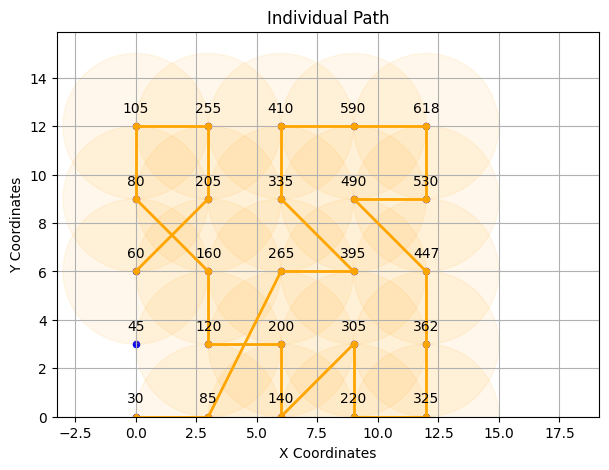

In [12]:
def plot_rewards(ax, reward_p: np.ndarray, reward_value: np.ndarray):
    ax.scatter(reward_p[:, 0], reward_p[:, 1], c='b', s=20, label='Rewards')
    for i, (x, y) in enumerate(reward_p):
        ax.annotate(reward_value[i], (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
    
    ax.set_xlabel("X Coordinates")
    ax.set_ylabel("Y Coordinates")


def plot_path(ax, reward_p: np.ndarray, individual: list, show_radius=False, show_path=True, color='orange'):
    total_distance = 0
    curr_reward = 0
    
    for next_reward in individual:
        if total_distance + dist_mx[curr_reward, next_reward] > BUDGET:
            break
        start = reward_p[curr_reward]
        end = reward_p[next_reward]
        if show_path:
            ax.plot([start[0], end[0]], [start[1], end[1]], linewidth=2, color=color, marker='o', markersize=4)

        if show_radius:
            circle = plt.Circle((end[0], end[1]), MAX_DISTANCE_BETWEEN_AGENTS, color=color, alpha=0.08)
            ax.add_patch(circle)
        
        total_distance += dist_mx[curr_reward, next_reward]
        curr_reward = next_reward

fig, ax = plt.subplots(figsize=(7, 5))

plot_rewards(ax, reward_p, reward_value)
plot_path(ax, reward_p, first_phase_individual, True)

ax.set_title("Individual Path")
plt.grid(True)
plt.axis('equal')
plt.ylim(0, None)
plt.xlim(0, None)

In [27]:
virtual_path = []
dist = 0
cp = 0
for p in first_phase_individual:
    if dist + dist_mx[cp, p] > BUDGET:
        break
    dist += dist_mx[cp, p]
    virtual_path.append(p)
    cp = p
virtual_path = np.array(virtual_path)
virtual_path

array([10, 15, 20, 21, 22, 12, 16, 17, 23, 24, 19, 18, 13, 14,  9,  8,  4,
        3,  2,  7,  6, 11,  5])

In [28]:
print(virtual_path[np.argsort(reward_value[virtual_path])])
np.argsort(reward_value[virtual_path])

[ 2  3  4 24  5  6 21 23  7  8  9 22 10 11 12 13 14 15 16 17 18 19 20]


array([18, 17, 16,  9, 22, 20,  3,  8, 19, 15, 14,  4,  0, 21,  5, 12, 13,
        1,  6,  7, 11, 10,  2])

In [29]:
def get_valid_points(p: int) -> list:
    current_point = reward_p[p]
    indices_within_radius = kdtree.query_radius([current_point], r=MAX_DISTANCE_BETWEEN_AGENTS)[0]
    return indices_within_radius

clusters = [
    get_valid_points(p) for p in virtual_path
]
valid_points = np.unique(np.concatenate(clusters))
valid_points

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

### Second Phase

In [30]:
mapping = {point: idx for idx, point in enumerate(valid_points)}
clusters = [np.array([mapping[point] for point in cluster]) for cluster in clusters]
clusters, mapping

([array([ 5, 10, 11, 15]),
  array([10, 15, 16, 20]),
  array([15, 20, 21]),
  array([16, 20, 21, 22]),
  array([17, 21, 22, 23]),
  array([ 7, 11, 12, 13, 17]),
  array([11, 15, 16, 17, 21]),
  array([12, 16, 17, 18, 22]),
  array([18, 22, 23, 24]),
  array([19, 23, 24]),
  array([14, 18, 19, 24]),
  array([13, 17, 18, 19, 23]),
  array([ 8, 12, 13, 14, 18]),
  array([ 9, 13, 14, 19]),
  array([ 4,  8,  9, 14]),
  array([ 3,  7,  8,  9, 13]),
  array([3, 4, 9]),
  array([2, 3, 4, 8]),
  array([1, 2, 3, 7]),
  array([ 2,  6,  7,  8, 12]),
  array([ 1,  5,  6,  7, 11]),
  array([ 6, 10, 11, 12, 16]),
  array([ 0,  5,  6, 10])],
 {np.int64(0): 0,
  np.int64(1): 1,
  np.int64(2): 2,
  np.int64(3): 3,
  np.int64(4): 4,
  np.int64(5): 5,
  np.int64(6): 6,
  np.int64(7): 7,
  np.int64(8): 8,
  np.int64(9): 9,
  np.int64(10): 10,
  np.int64(11): 11,
  np.int64(12): 12,
  np.int64(13): 13,
  np.int64(14): 14,
  np.int64(15): 15,
  np.int64(16): 16,
  np.int64(17): 17,
  np.int64(18): 18,
  np.

In [31]:
def init_individual(icls) -> list:
    perm1 = []
    perm2 = []

    visited_points = set()

    for cluster_points in clusters:
        unique_points = [p for p in cluster_points if p not in visited_points]

        if unique_points:
            shuffled_points1 = np.random.permutation(unique_points)
            shuffled_points2 = np.random.permutation(unique_points)

            perm1.extend(shuffled_points1)
            perm2.extend(shuffled_points2)

            visited_points.update(unique_points)

    genes = np.array([perm1, perm2])

    num_columns = genes.shape[1]
    shuffled_indices = np.random.permutation(num_columns)

    genes = genes[:, shuffled_indices]

    return icls(genes)

In [32]:
def mut_individual(individual: list, indpb: float) -> tuple:
    path1, path2 = individual
    tools.mutShuffleIndexes(path1, indpb=indpb)
    tools.mutShuffleIndexes(path2, indpb=indpb)
    return (individual,)

In [33]:
def cx_partialy_matched(ind1: np.ndarray, ind2: np.ndarray) -> tuple:
    size = ind1.shape[1]
    
    cxpoint1, cxpoint2 = sorted(random.sample(range(size), 2))
    
    for row in range(ind1.shape[0]):
        p1, p2 = np.zeros(size, dtype=int), np.zeros(size, dtype=int)
        
        for i in range(size):
            p1[ind1[row][i]] = i
            p2[ind2[row][i]] = i

        for i in range(cxpoint1, cxpoint2):
            temp1 = ind1[row, i]
            temp2 = ind2[row, i]

            ind1[row, i], ind2[row, i] = temp2, temp1
            
            ind1[row, p1[temp2]] = temp1
            ind2[row, p2[temp1]] = temp2

            p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
            p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

    return ind1, ind2

def cx_individual(ind1: list, ind2: list) -> tuple:
    tools.cxPartialyMatched(ind1[0], ind2[0])
    tools.cxPartialyMatched(ind1[1], ind2[1])
    return ind1, ind2

In [34]:
def second_phase_maximize_reward(ind: list) -> float:
    visited = set()
    fitness = 0

    for path in ind:
        last_idx = get_last_valid_idx(path)

        for i in range(last_idx + 1):
            next_reward = path[i]

            if not next_reward in visited:
                fitness += reward_value[next_reward]
                visited.add(next_reward)

    return fitness

def second_phase_minimize_distance(ind: list) -> float:
    total_distance = 0
    for path in ind:
        curr_reward = 0
        for next_reward in path:
            total_distance += dist_mx[curr_reward, next_reward]
            curr_reward = next_reward

    return total_distance

def minimize_distance_between_agents(ind: list) -> float:
    last_idx1 = get_last_valid_idx(ind[0])
    last_idx2 = get_last_valid_idx(ind[1])
    min_last_idx = min(last_idx1, last_idx2)

    full_distance = 0

    for p1, p2 in zip(ind[0][:min_last_idx], ind[1][:min_last_idx]):
        full_distance += dist_mx[p1, p2]

    if last_idx1 > last_idx2:
        for p1 in ind[0][min_last_idx:last_idx1]:
            full_distance += dist_mx[p1, p2]
    elif last_idx2 > last_idx1:
        for p2 in ind[1][min_last_idx:last_idx2]:
            full_distance += dist_mx[p1, p2]

    return full_distance

def penalize_distance(ind: list) -> float:
    last_idx1 = get_last_valid_idx(ind[0])
    last_idx2 = get_last_valid_idx(ind[1])
    min_last_idx = min(last_idx1, last_idx2)

    for p1, p2 in zip(ind[0][:min_last_idx+1], ind[1][:min_last_idx+1]):
        if dist_mx[p1, p2] > MAX_DISTANCE_BETWEEN_AGENTS:
            return True

    if last_idx1 > last_idx2:
        for p1 in ind[0][min_last_idx+1:last_idx1]:
            if dist_mx[p1, ind[1][min_last_idx - 1]] > MAX_DISTANCE_BETWEEN_AGENTS:
                return True
    elif last_idx2 > last_idx1:
        for p2 in ind[1][min_last_idx+1:last_idx2]:
            if dist_mx[ind[0][min_last_idx - 1], p2] > MAX_DISTANCE_BETWEEN_AGENTS:
                return True

    return False


def second_phase_evaluate(ind: list, gen: int) -> float:
    mapped_ind = []
    for path in ind:
        mapped_path = [valid_points[point] for point in path]
        mapped_ind.append(mapped_path)

    max_reward = second_phase_maximize_reward(mapped_ind)
    min_distance = second_phase_minimize_distance(mapped_ind)
    min_distance_between_agents = minimize_distance_between_agents(mapped_ind)

    penalize_dist = penalize_distance(mapped_ind)

    if penalize_dist and gen > NUM_GEN // 2:
        return (-1000, min_distance + 5000, min_distance_between_agents + 5000)
    elif penalize_dist:
        reward_penalty = 500 * (1 + gen / NUM_GEN)
        distance_penalty = 1000 * (1 + gen / NUM_GEN)
        return (max_reward - reward_penalty, min_distance + distance_penalty, min_distance_between_agents + distance_penalty)

    return (max_reward, min_distance, min_distance_between_agents)

In [35]:
POP_SIZE = 800
NUM_GEN = 1000

CX_PROB = 0.8
MUT_PROB = 0.5
TOURNAMENT_SIZE = 2

MAX_DISTANCE_BETWEEN_AGENTS = 4.
BUDGET = 80

In [36]:
def create_second_toolbox():
    creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, -1.0))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)

    toolbox = base.Toolbox()

    toolbox.register("individual", init_individual, creator.Individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", cx_individual)
    toolbox.register("mutate", mut_individual, indpb=0.1)
    toolbox.register("select", tools.selNSGA2)
    toolbox.register("evaluate", second_phase_evaluate)
    return toolbox

In [37]:
def plot_distances(path1, path2):
    last_idx = min(get_last_valid_idx(path1), get_last_valid_idx(path2))
    fig, ax = plt.subplots(figsize=(10, 5))
    dist = []
    for p1, p2 in zip(path1[:last_idx+1], path2[:last_idx+1]):
        dist.append(dist_mx[p1, p2])
    ax.plot(range(len(dist)), dist, color='red', marker='o')
    ax.set_ylabel("Distance between agents")
    ax.set_title("Distance between agents in the two paths. Max distance allowed: 3.5")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [38]:
population2, logbook2 = evolve(create_second_toolbox(), seed=42)

C:\Users\dti Digital\AppData\Roaming\Python\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\dti Digital\AppData\Roaming\Python\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


avg    	gen	max    	min 	std    
744.484	0  	1482.71	-193	534.458
760.145	1  	1469.93	-168	497.662
744.205	2  	1471.04	-168	483.703
732.537	3  	1468.93	-168	472.724
709.944	4  	1453.23	-78 	466.914
678.173	5  	1442.1 	-7  	461.683
636.012	6  	1443.89	0   	454.341
596.713	7  	1443.89	0   	444.484
561.407	8  	1440.46	0   	433.45 
524.607	9  	1440.46	0   	418.43 
501.498	10 	1441.37	0   	406.925
481.935	11 	1440.46	0   	396.433
445.499	12 	1427.04	0   	373.079
430.178	13 	1424.09	0   	361.314
416.243	14 	1419.44	0   	349.928
407.048	15 	1408.28	0   	341.272
388.193	16 	1408.28	0   	323.742
363.138	17 	1408.28	0   	298.016
372.727	18 	1408.28	0   	304.558
375.054	19 	1399.57	0   	307.464
364.029	20 	1404.42	0   	295.427
356.564	21 	1404.42	0   	286.898
355.712	22 	1406.42	0   	286.681
339.825	23 	1372.12	0   	267.707
341.44 	24 	862    	0   	269.384
342.298	25 	862    	0   	271.096
341.176	26 	862    	0   	271.08 
342.675	27 	862    	0   	272.537
345.192	28 	862    	0   	274.164
349.241	29

In [39]:
pareto_front = tools.emo.sortLogNondominated(population2, len(population2), first_front_only=True)
pareto_front

[Individual([[ 5, 15, 23, 14,  4,  7, 24, 19, 11, 21, 16, 13,  8,  2,  3,
               9, 12, 18, 22, 17, 20,  0,  1,  6, 10],
             [10, 20, 23,  9,  3,  6, 24, 19, 12, 22, 17, 18, 14,  4,  2,
               7, 11, 16, 21, 15,  5,  0,  1,  8, 13]]),
 Individual([[ 5, 15, 23, 14,  4,  7, 24, 19, 11, 21, 16, 13,  8,  2,  3,
               9, 12, 18, 22, 17, 20,  0,  1,  6, 10],
             [10, 20, 23,  9,  3,  6, 24, 19, 12, 22, 17, 18, 14,  4,  2,
               7, 11, 16, 21, 15,  5,  0,  1,  8, 13]]),
 Individual([[ 5, 15, 18, 14,  2,  7, 24, 19, 11, 21, 16, 12,  8,  4,  3,
               9, 13, 23, 22, 17, 20,  0,  1,  6, 10],
             [10, 20, 23,  9,  7,  6, 24, 19, 12, 22, 17, 13,  8,  4,  3,
               2, 11, 16, 21, 15,  5,  0,  1, 14, 18]]),
 Individual([[ 5, 15, 18, 14,  2,  7, 24, 19, 11, 21, 16, 12,  8,  4,  3,
               9, 13, 23, 22, 17, 20,  0,  1,  6, 10],
             [10, 20, 23,  9,  7,  6, 24, 19, 12, 22, 17, 13,  8,  4,  3,
               2,

In [40]:
second_phase_individual = pareto_front[0]

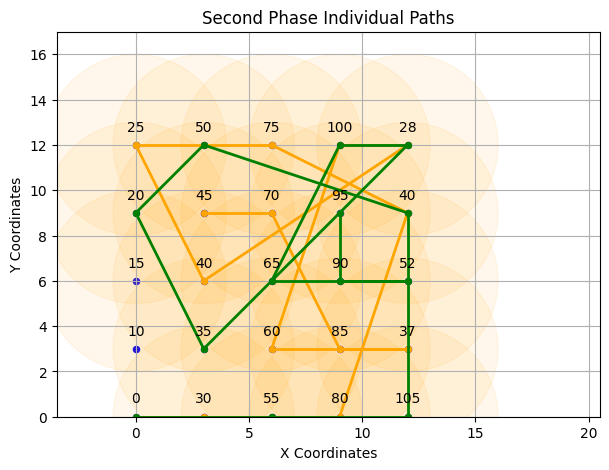

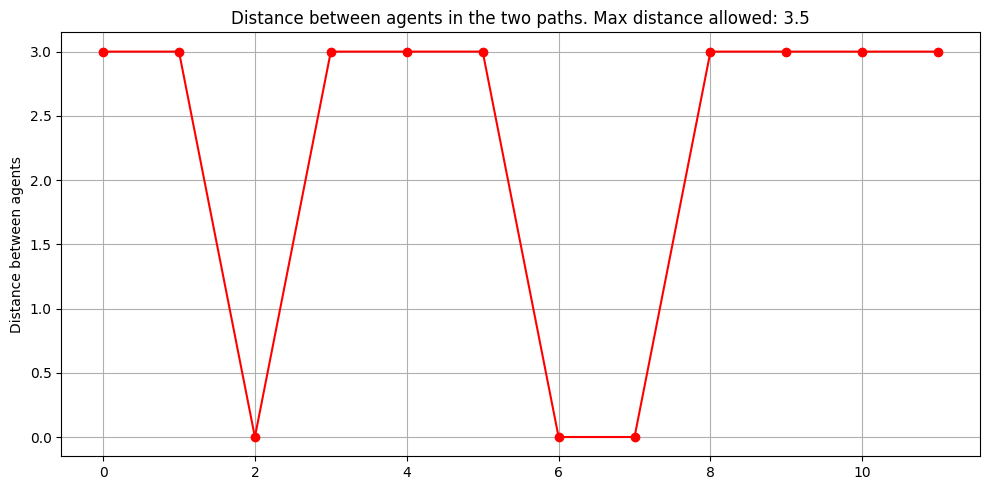

In [41]:
mapped_second_phase_individual = [np.array([valid_points[p] for p in perm]) for perm in second_phase_individual]

fig, ax = plt.subplots(figsize=(7, 5))

plot_rewards(ax, reward_p, reward_value)
plot_path(ax, reward_p, first_phase_individual, show_path=False, show_radius=True)
plot_path(ax, reward_p, mapped_second_phase_individual[0], color='orange')
plot_path(ax, reward_p, mapped_second_phase_individual[1], color='green')

ax.set_title("Second Phase Individual Paths")
plt.grid(True)
plt.axis('equal')
plt.ylim(0, None)
plt.xlim(0, None)
plt.show()
plot_distances(mapped_second_phase_individual[0], mapped_second_phase_individual[1])